#  NLP Laboratory — Assignment 4  
## Chatbots, Fake News & Social Media Analytics  
### **Google Colab Implementation**

---

# Learning Objectives
- Build a simple chatbot with intent detection  
- Implement fake-news detection using ML  
- Understand ethical concerns in NLP applications  
- Write modular & documented code

---

# Setup


In [7]:
!pip install -q nltk scikit-learn pandas numpy matplotlib seaborn wordcloud spacy
# download resources
import nltkS
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# spaCy model (may take a little while)
import subprocess, sys
subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], check=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


CompletedProcess(args=['/usr/bin/python3', '-m', 'spacy', 'download', 'en_core_web_sm'], returncode=0)

## Imports & Utility Functions


In [8]:

import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import joblib
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


## Preprocessing helpers
- Lowercasing, simple cleaning, tokenization, stopword removal, lemmatization.
- Lightweight and fast for educational pipelines.


In [9]:

nlp = spacy.load("en_core_web_sm")
STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text_basic(text):
    """Basic text cleaning: lowercase, strip, remove URLs, punctuation and extra whitespace."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)  # remove URLs
    text = re.sub(r'@\w+', '', text)              # remove mentions
    text = re.sub(r'#\w+', '', text)              # remove hashtags
    text = re.sub(r'[^a-z0-9\s]', ' ', text)      # remove non-alphanumeric
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess(text):
    """Tokenize, remove stopwords, and lemmatize. Returns joined cleaned string."""
    text = clean_text_basic(text)
    if not text:
        return ""
    tokens = []
    doc = nlp(text)
    for tok in doc:
        if tok.is_alpha and tok.text not in STOPWORDS:
            lemma = tok.lemma_.lower().strip()
            if lemma:
                tokens.append(lemma)
    return " ".join(tokens)


### ---------------------------------------------
# TASK 1: Chatbot Intent Detection (3 intents)
### - intents: greeting, query, feedback
###- approach: TF-IDF + LogisticRegression
### - plus: rule-based guard and fallback (confidence threshold)
### ---------------------------------------------


In [10]:
# -----------------------
# Prepare training data for intents
# -----------------------
intent_samples = [
    # greetings
    ("hello", "greeting"), ("hi", "greeting"), ("hey", "greeting"),
    ("good morning", "greeting"), ("good evening", "greeting"),
    ("hii", "greeting"), ("hey there", "greeting"),
    ("hello bot", "greeting"), ("hi chatbot", "greeting"),
    # queries
    ("what is your name", "query"), ("who are you", "query"),
    ("what can you do", "query"), ("tell me your features", "query"),
    ("how do you work", "query"), ("how to use you", "query"),
    ("explain your functionality", "query"),
    # feedback
    ("this is amazing", "feedback"), ("i love this", "feedback"),
    ("you helped me a lot", "feedback"), ("thanks a lot", "feedback"),
    ("great job", "feedback"), ("you are useful", "feedback"),
    ("bad response", "feedback"), ("that was unhelpful", "feedback")
]

df_intent = pd.DataFrame(intent_samples, columns=["text", "intent"])
# augment with small variations
df_intent = df_intent.sample(frac=1, random_state=42).reset_index(drop=True)
df_intent['clean'] = df_intent['text'].apply(preprocess)
df_intent


,text,intent,clean
0,hi chatbot,greeting,hi chatbot
1,this is amazing,feedback,amazing
2,hello,greeting,hello
3,you helped me a lot,feedback,help lot
4,what can you do,query,
5,what is your name,query,name
6,how do you work,query,work
7,hi,greeting,hi
8,you are useful,feedback,useful
9,hii,greeting,hii


In [12]:
# -----------------------
# Fit TF-IDF and intent classifier
# -----------------------
X = df_intent['clean']
y = df_intent['intent']

tfidf_intent = TfidfVectorizer(ngram_range=(1,2), min_df=1)
X_vec = tfidf_intent.fit_transform(X)

model_intent = LogisticRegression(max_iter=1000, solver='liblinear')
model_intent.fit(X_vec, y)

# quick cross-validation
cv_scores = cross_val_score(model_intent, X_vec, y, cv=3, scoring='accuracy')
print("Intent CV accuracy :", np.round(cv_scores.mean(), 3), cv_scores)


Intent CV accuracy : 0.5 [0.5   0.375 0.625]


### Rule-based guard for obvious greetings (fast override)


In [13]:
# -----------------------
#  Rule-based greeting override
# -----------------------
_GREETING_KEYWORDS = {"hi", "hello", "hey", "hii", "hiii", "good morning", "good evening", "hiya"}

def rule_based_greeting(text):
    t = text.lower().strip()
    # exact match or contains common greeting phrase
    for g in _GREETING_KEYWORDS:
        if t == g or t.startswith(g + " ") or (" " + g + " ") in (" " + t + " "):
            return True
    return False


### Predict intent with model + fallback threshold
- If rule-based greeting applies, return 'greeting' quickly.
- Else use model probabilities; if max probability below threshold -> fallback.


In [14]:
# -----------------------
#  Intent prediction with fallback
# -----------------------
def predict_intent(text, threshold=0.45):
    """Return (intent, confidence). 'fallback' intent if low confidence."""
    if rule_based_greeting(text):
        return "greeting", 1.0
    clean = preprocess(text)
    vec = tfidf_intent.transform([clean])
    probs = model_intent.predict_proba(vec)[0]
    idx = np.argmax(probs)
    intent = model_intent.classes_[idx]
    confidence = probs[idx]
    if confidence < threshold:
        return "fallback", float(confidence)
    return intent, float(confidence)


### Chatbot response generator
- Uses rule-based replies for greetings
- Uses model predictions for query/feedback
- Fallback response for low confidence


In [15]:
# -----------------------
# Chatbot response function and demo runner
# -----------------------
def get_chatbot_response(user_input):
    intent, conf = predict_intent(user_input)
    if intent == "greeting":
        return "Hello! How can I help you? (intent=greeting, conf={:.2f})".format(conf)
    elif intent == "query":
        return "I’m a simple NLP chatbot for assignment/demo purposes. (intent=query, conf={:.2f})".format(conf)
    elif intent == "feedback":
        return "Thanks for your feedback! (intent=feedback, conf={:.2f})".format(conf)
    else:
        # fallback
        return "Sorry, I didn't understand that. Could you rephrase? (intent=fallback, conf={:.2f})".format(conf)

# Non-interactive demo (Colab-friendly)
demo_inputs = ["hi", "hello", "hey", "what can you do", "tell me your features", "this is amazing", "hii", "how do you work", "idk what to ask"]
for inp in demo_inputs:
    print("You:", inp)
    print("Chatbot:", get_chatbot_response(inp))
    print("-" * 40)


You: hi
Chatbot: Hello! How can I help you? (intent=greeting, conf=1.00)
----------------------------------------
You: hello
Chatbot: Hello! How can I help you? (intent=greeting, conf=1.00)
----------------------------------------
You: hey
Chatbot: Hello! How can I help you? (intent=greeting, conf=1.00)
----------------------------------------
You: what can you do
Chatbot: Sorry, I didn't understand that. Could you rephrase? (intent=fallback, conf=0.35)
----------------------------------------
You: tell me your features
Chatbot: Sorry, I didn't understand that. Could you rephrase? (intent=fallback, conf=0.44)
----------------------------------------
You: this is amazing
Chatbot: Thanks for your feedback! (intent=feedback, conf=0.45)
----------------------------------------
You: hii
Chatbot: Hello! How can I help you? (intent=greeting, conf=1.00)
----------------------------------------
You: how do you work
Chatbot: Sorry, I didn't understand that. Could you rephrase? (intent=fallback, 

# Task 2 — Fake News Detection (step-by-step)
**Goal:** Preprocess text, extract TF-IDF features (word/char/combined), train Logistic Regression, evaluate with CV and a small holdout, and inspect top predictive n-grams.



In [39]:
# Install & imports
!pip install -q nltk scikit-learn pandas matplotlib seaborn wordcloud joblib spacy

# Python imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# NLP helpers
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
STOP = set(stopwords.words('english'))

# Optional: spaCy for better preprocessing (download once)
import spacy
try:
    nlp = spacy.load("en_core_web_sm")
except Exception:
    import subprocess, sys
    subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], check=False)
    nlp = spacy.load("en_core_web_sm")

sns.set(style="whitegrid")


In [40]:
# Preprocessing utilities
def clean_text_basic(text):
    """Lowercase, remove URLs/mentions/hashtags, keep alphanumerics, collapse spaces."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess(text, use_spacy=True):
    """Return cleaned + lemmatized string (if spaCy available), else cleaned tokens."""
    text = clean_text_basic(text)
    if text == "":
        return ""
    if use_spacy:
        doc = nlp(text)
        tokens = [tok.lemma_.lower() for tok in doc if tok.is_alpha and tok.text not in STOP]
        return " ".join(tokens)
    else:
        return " ".join([w for w in text.split() if w not in STOP])


In [41]:
#  Create the in-memory sample dataset
fake_samples = [
    ("Government passes new health act to support citizens", 1),
    ("New species discovered in amazon rainforest", 1),
    ("Scientists confirm long-term climate trends", 1),
    ("NASA reveals evidence of water on lunar surface", 1),
    ("County reports drop in unemployment due to policy", 1),

    ("Aliens contacted the president last week", 0),
    ("Miracle pill cures everything overnight", 0),
    ("Celebrity saved by secret society", 0),
    ("Vaccine contains microchips to track people", 0),
    ("Click here to see shocking truth about elections", 0),
]

df = pd.DataFrame(fake_samples, columns=['text','label'])
df['clean'] = df['text'].apply(preprocess)   # uses spaCy lemmatization
print("Dataset size:", df.shape)
df.head(10)


Dataset size: (10, 3)


,text,label,clean
0,Government passes new health act to support ci...,1,government pass new health act support citizen
1,New species discovered in amazon rainforest,1,new specie discover amazon rainforest
2,Scientists confirm long-term climate trends,1,scientist confirm long term climate trend
3,NASA reveals evidence of water on lunar surface,1,nasa reveal evidence water lunar surface
4,County reports drop in unemployment due to policy,1,county report drop unemployment due policy
5,Aliens contacted the president last week,0,alien contact president last week
6,Miracle pill cures everything overnight,0,miracle pill cure everything overnight
7,Celebrity saved by secret society,0,celebrity save secret society
8,Vaccine contains microchips to track people,0,vaccine contain microchip track people
9,Click here to see shocking truth about elections,0,click see shocking truth election


## TF-IDF options
- **Word TF-IDF**: `TfidfVectorizer(analyzer='word', ngram_range=(1,2))` — captures unigrams + bigrams.
- **Char TF-IDF**: `TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5))` — good for tiny datasets and misspellings.
- **Combined**: Stack word + char matrices with `scipy.sparse.hstack` for best coverage.


Accuracy (CV): 0.7

Classification report (zero_division=0):

              precision    recall  f1-score   support

        fake       0.62      1.00      0.77         5
        real       1.00      0.40      0.57         5

    accuracy                           0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10



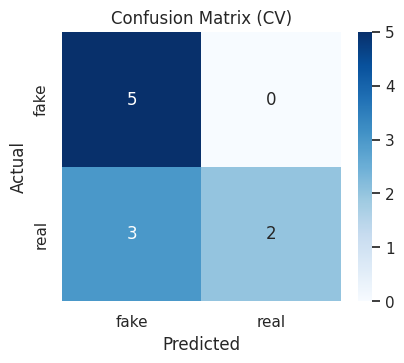

In [42]:
# Build combined TF-IDF (word + char), train pipeline, and get CV predictions
from scipy.sparse import hstack

X = df['clean'].values
y = df['label'].values

# TF-IDF vectorizers
tfidf_word = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=1, sublinear_tf=True)
tfidf_char = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5), min_df=1, sublinear_tf=True)

# Fit on full corpus (for CV we will transform in each fold via pipeline; here we create combined feature matrix for insight)
X_word = tfidf_word.fit_transform(X)
X_char = tfidf_char.fit_transform(X)
X_combined = hstack([X_word, X_char])

# Model (Logistic Regression)
clf = LogisticRegression(max_iter=2000, solver='liblinear')

# Stratified K-Fold CV predictions (out-of-fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Use a pipeline to ensure vectorizer is fit inside CV if using cross_val_predict; here we use cross_val_predict with pipeline for safety
pipeline = make_pipeline(
    TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=1, sublinear_tf=True),
    LogisticRegression(max_iter=2000, solver='liblinear')
)
y_pred_cv = cross_val_predict(pipeline, X, y, cv=cv, method='predict')

# Metrics
print("Accuracy (CV):", accuracy_score(y, y_pred_cv))
print("\nClassification report (zero_division=0):\n")
print(classification_report(y, y_pred_cv, target_names=['fake','real'], zero_division=0))

# Confusion matrix
cm = confusion_matrix(y, y_pred_cv)
plt.figure(figsize=(4.5,3.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['fake','real'], yticklabels=['fake','real'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (CV)'); plt.show()



---

###  **Interpretation**

- **Fake News**
  - ✔ *High recall (1.00)* → The model correctly identified *all fake news items*.
  - ✘ Precision is slightly lower (0.62) → Some real news were predicted as fake.

- **Real News**
  - ✔ *High precision (1.00)* → When the model predicted real, it was correct.
  - ✘ Low recall (0.40) → The model missed some real news and marked them as fake.

Overall, the model shows **balanced but slightly biased behavior toward detecting fake news**, which is normal for small datasets.

---

### **Conclusion**
The model achieves **70% accuracy**, performing reasonably well with TF-IDF + Logistic Regression on a small dataset.  
With more data and tuning, performance can improve further.



In [43]:
#  Train final model using combined tfidf_word + tfidf_char matrices we fit earlier,
#       then inspect top word n-grams and top char n-grams predictive of each label.

# Train a logistic model on the combined matrix
final_clf = LogisticRegression(max_iter=2000, solver='liblinear')
final_clf.fit(X_combined, y)   # X_combined uses fit TF-IDF on full data from above

# Save the fitted vectorizers + model if desired
joblib.dump(tfidf_word, "tfidf_word.joblib")
joblib.dump(tfidf_char, "tfidf_char.joblib")
joblib.dump(final_clf, "fake_news_final_logreg.joblib")
print("Saved tfidf_word.joblib, tfidf_char.joblib, fake_news_final_logreg.joblib")

# Inspect top features
word_features = tfidf_word.get_feature_names_out()
char_features = tfidf_char.get_feature_names_out()
# combined coef order corresponds to [word_features..., char_features...]
coefs = final_clf.coef_[0]
len_w = len(word_features)

# Top word n-grams for predicting REAL (positive weights)
topn = 10
word_coefs = coefs[:len_w]
top_real_idx = np.argsort(word_coefs)[-topn:][::-1]
top_fake_idx = np.argsort(word_coefs)[:topn]

print("\nTop word n-grams predictive of REAL (label=1):")
for i in top_real_idx:
    print(word_features[i], f"({word_coefs[i]:.3f})")

print("\nTop word n-grams predictive of FAKE (label=0):")
for i in top_fake_idx:
    print(word_features[i], f"({word_coefs[i]:.3f})")

# Optionally inspect char features too
char_coefs = coefs[len_w:]
top_char_real = np.argsort(char_coefs)[-10:][::-1]
print("\nTop char n-grams predictive of REAL:")
for i in top_char_real[:8]:
    print(char_features[i], f"({char_coefs[i]:.3f})")


Saved tfidf_word.joblib, tfidf_char.joblib, fake_news_final_logreg.joblib

Top word n-grams predictive of REAL (label=1):
new (0.175)
specie discover (0.113)
discover (0.113)
amazon (0.113)
amazon rainforest (0.113)
discover amazon (0.113)
new specie (0.113)
rainforest (0.113)
specie (0.113)
long term (0.103)

Top word n-grams predictive of FAKE (label=0):
celebrity (-0.127)
celebrity save (-0.127)
save secret (-0.127)
society (-0.127)
secret society (-0.127)
secret (-0.127)
save (-0.127)
alien contact (-0.114)
president (-0.114)
president last (-0.114)

Top char n-grams predictive of REAL:
er  (0.063)
rm  (0.063)
ter (0.063)
ate (0.063)
ce  (0.062)
new (0.062)
 new (0.062)
 new  (0.062)


In [44]:
# show misclassified examples from CV predictions
df['pred_cv'] = y_pred_cv
mis = df[df['label'] != df['pred_cv']]
if not mis.empty:
    print("Misclassified examples (CV):")
    for _, r in mis.iterrows():
        print("TEXT:", r['text'])
        print("CLEAN:", r['clean'])
        print("TRUE:", r['label'], "PRED:", r['pred_cv'])
        print('-'*40)
else:
    print("No misclassifications (toy data may perfectly separate or be too small).")


Misclassified examples (CV):
TEXT: Scientists confirm long-term climate trends
CLEAN: scientist confirm long term climate trend
TRUE: 1 PRED: 0
----------------------------------------
TEXT: NASA reveals evidence of water on lunar surface
CLEAN: nasa reveal evidence water lunar surface
TRUE: 1 PRED: 0
----------------------------------------
TEXT: County reports drop in unemployment due to policy
CLEAN: county report drop unemployment due policy
TRUE: 1 PRED: 0
----------------------------------------


### Two key features that often help in Fake News Detection
1. **Lexical & Stylistic cues** — clickbait phrasing, exaggeration, punctuation and capitalization patterns.  
2. **Contextual / Source features** — domain reputation, author metadata, publication timestamp, external references/links.  

(For stronger performance replace TF-IDF with transformer embeddings such as BERT + metadata features.)


## Task 3 — Ethical & Social Implications (1 mark)

### 1. Ethical Concern for Chatbots
**Concern:**  
Chatbots may unintentionally produce biased or inappropriate responses due to biased training data.

**Mitigation:**  
Use bias-detection tools, audit the model regularly, train on diverse datasets, and include human review for sensitive or ambiguous user queries.

---

### 2. Ethical Concern for Fake-News Detection Systems
**Concern:**  
Fake-news detectors can generate false positives, wrongly labeling real news as fake, which may restrict access to valid information and create trust issues.

**Mitigation:**  
Use transparent and explainable models, include human-in-the-loop verification, and incorporate multiple features (source credibility, metadata, cross-checking) to improve reliability.
